# Iterative하게 모든 SAMPLE에 대해서 Training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기

In [3]:
data = pd.read_csv('./TrafficData/1-Copy1.csv')
data = data['volumn']
sequence_length = 1440
pred_len = 1

In [4]:
from torch import FloatTensor as FloatTensor

In [16]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length])

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [6]:
split = 10080

In [7]:
seed = 42

In [8]:
device = torch.device("cuda:0")

In [9]:
X_test = torch.FloatTensor(data.iloc[-split-sequence_length:-split].values).to(device)
# X_train의 마지막 인덱스에서 sequece_length만큼 뒤에 부분을 잘라오기
X_test = X_test.view(1,1,sequence_length)

In [10]:
target = data.iloc[-split]
target = FloatTensor([target]).view(-1,1)
target

tensor([[2802986.]])

In [11]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

# 2. Train-Validation set으로 쪼개기

In [12]:
data

0        2755201
1        2756000
2        2755897
3        2755301
4        2756166
          ...   
38875    2789520
38876    2788218
38877    2789770
38878    2788755
38879    2788395
Name: volumn, Length: 38880, dtype: int64

* 10080개는 test set 
* 28800개 중 0.2의 비율인 1440*4 = 5760개는 validation set
* 28800개 중 0.8의 비율인 28800-5760 = 23040개는 train set

In [17]:
train = data.iloc[:-split-5760]
val = data.iloc[-split-5760:-split]
x_train,y_train = seq_data(train,sequence_length=1440,pred_len=1)
x_val,y_val = seq_data(val,sequence_length=1440,pred_len=1)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_744225/2450292848.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [20]:
next(iter(validation))[0].size()

torch.Size([64, 1, 1440])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [21]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(1440)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = SMAPE()
num_epochs = 100
n= len(training)

### 기본 모델 training

In [22]:
import copy

In [23]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=200
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)
        
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 1.550
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 1.911
Epoch [41]/[100] running accumulative loss across all batches: 1.744
Epoch [61]/[100] running accumulative loss across all batches: 2.105
changed
Epoch [81]/[100] running accumulative loss across all batches: 1.142
changed


### validation set에 대해서 attribution 구하기

In [24]:
n = len(validation)
n

68

In [30]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,1440))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [31]:
len(nt_ig_attr_score)

1440

<AxesSubplot: >

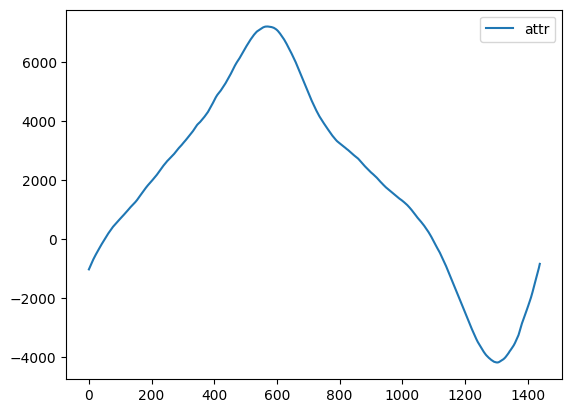

In [32]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

In [34]:
attr_df = attr_df/attr_df.std()
attr_df

,attr
0,-0.320683
1,-0.313082
2,-0.304720
3,-0.296845
4,-0.288536
...,...
1435,-0.320243
1436,-0.306214
1437,-0.291730
1438,-0.276740


<AxesSubplot: >

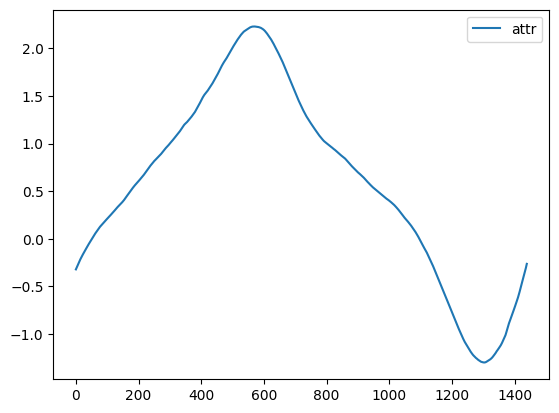

In [35]:
attr_df.plot()

In [36]:
attr_df.describe()

,attr
count,1440.000000
mean,0.574139
std,1.000000
min,-1.297916
25%,-0.101577
50%,0.621690
75%,1.301154
max,2.229270


### outlier가 감쇄 됐음을 확인할 수 있다.

#### scaling

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,-0.895133
1,-0.887529
2,-0.879165
3,-0.871287
4,-0.862974
...,...
1435,-0.894693
1436,-0.880659
1437,-0.866170
1438,-0.851174


#### train_index구하기

<AxesSubplot: >

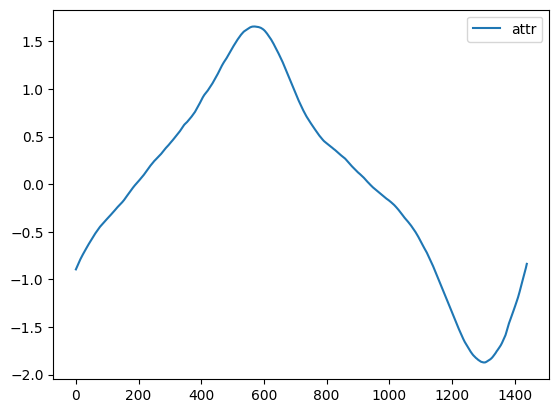

In [29]:
attr_df.plot()

In [2]:
index_list = []

for hyper_parameter in np.arange(0.01,1.01,0.01):
    append_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

NameError: name 'attr_df' is not defined

In [23]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


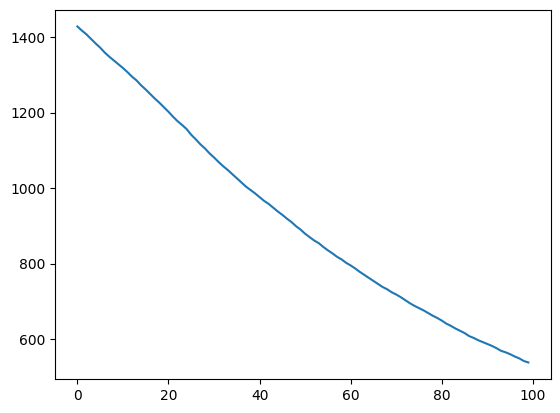

In [24]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [25]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[2796723., 2797804., 2797755.,  ..., 2801658., 2803101., 2801166.]],

        [[2797804., 2797755., 2797568.,  ..., 2803101., 2801166., 2799554.]],

        [[2797755., 2797568., 2796800.,  ..., 2801166., 2799554., 2799881.]],

        ...,

        [[2794154., 2794044., 2794871.,  ..., 2798282., 2797734., 2797158.]],

        [[2794044., 2794871., 2795820.,  ..., 2797734., 2797158., 2796599.]],

        [[2794871., 2795820., 2794320.,  ..., 2797158., 2796599., 2798303.]]],
       device='cuda:0') tensor([[[2799554.]],

        [[2799881.]],

        [[2800790.]],

        [[2800803.]],

        [[2800713.]],

        [[2800685.]],

        [[2801527.]],

        [[2801293.]],

        [[2800512.]],

        [[2800479.]],

        [[2800530.]],

        [[2799355.]],

        [[2799549.]],

        [[2799119.]],

        [[2799878.]],

        [[2800577.]],

        [[2799074.]],

        [[2799797.]],

        [[2799311.]],

        [[2799278.]],

        [[2799274.]],

     

       device='cuda:0') tensor([[[2802787.]],

        [[2803520.]],

        [[2802898.]],

        [[2803221.]],

        [[2804049.]],

        [[2803243.]],

        [[2804328.]],

        [[2803409.]],

        [[2802964.]],

        [[2803052.]],

        [[2802898.]],

        [[2803639.]],

        [[2802086.]],

        [[2803657.]],

        [[2803136.]],

        [[2803994.]],

        [[2801626.]],

        [[2802614.]],

        [[2801926.]],

        [[2801969.]],

        [[2802427.]],

        [[2802835.]],

        [[2801559.]],

        [[2800645.]],

        [[2801660.]],

        [[2801070.]],

        [[2801895.]],

        [[2801775.]],

        [[2801503.]],

        [[2800541.]],

        [[2799469.]],

        [[2799681.]],

        [[2799990.]],

        [[2800397.]],

        [[2800065.]],

        [[2799806.]],

        [[2799601.]],

        [[2799171.]],

        [[2798991.]],

        [[2798810.]],

        [[2798840.]],

        [[2797993.]],

        [[

       device='cuda:0') tensor([[[2814440.]],

        [[2815442.]],

        [[2816458.]],

        [[2816805.]],

        [[2816497.]],

        [[2815212.]],

        [[2816421.]],

        [[2816924.]],

        [[2815627.]],

        [[2815830.]],

        [[2813737.]],

        [[2815924.]],

        [[2815351.]],

        [[2815432.]],

        [[2815989.]],

        [[2815431.]],

        [[2816834.]],

        [[2816927.]],

        [[2815581.]],

        [[2816258.]],

        [[2815685.]],

        [[2816698.]],

        [[2815949.]],

        [[2814968.]],

        [[2816008.]],

        [[2816534.]],

        [[2816868.]],

        [[2816934.]],

        [[2816299.]],

        [[2815673.]],

        [[2816151.]],

        [[2815985.]],

        [[2817037.]],

        [[2817305.]],

        [[2818046.]],

        [[2816445.]],

        [[2816081.]],

        [[2816220.]],

        [[2816894.]],

        [[2815954.]],

        [[2816386.]],

        [[2817008.]],

        [[

tensor([[[2787005., 2787864., 2786590.,  ..., 2781763., 2782422., 2782479.]],

        [[2787864., 2786590., 2786721.,  ..., 2782422., 2782479., 2782979.]],

        [[2786590., 2786721., 2786608.,  ..., 2782479., 2782979., 2783268.]],

        ...,

        [[2785554., 2785755., 2787186.,  ..., 2783420., 2784190., 2783885.]],

        [[2785755., 2787186., 2786285.,  ..., 2784190., 2783885., 2783844.]],

        [[2787186., 2786285., 2786154.,  ..., 2783885., 2783844., 2784252.]]],
       device='cuda:0') tensor([[[2782979.]],

        [[2783268.]],

        [[2782243.]],

        [[2782336.]],

        [[2782566.]],

        [[2783350.]],

        [[2782697.]],

        [[2782614.]],

        [[2782945.]],

        [[2783078.]],

        [[2783200.]],

        [[2783419.]],

        [[2782411.]],

        [[2783158.]],

        [[2781768.]],

        [[2782035.]],

        [[2782654.]],

        [[2782150.]],

        [[2782500.]],

        [[2782648.]],

        [[2783217.]],

     

       device='cuda:0') tensor([[[2836063.]],

        [[2834508.]],

        [[2835379.]],

        [[2833508.]],

        [[2835466.]],

        [[2836082.]],

        [[2835405.]],

        [[2835384.]],

        [[2835029.]],

        [[2837422.]],

        [[2835484.]],

        [[2835076.]],

        [[2834901.]],

        [[2835928.]],

        [[2835119.]],

        [[2834957.]],

        [[2834578.]],

        [[2834797.]],

        [[2834542.]],

        [[2834625.]],

        [[2834092.]],

        [[2836029.]],

        [[2835669.]],

        [[2835557.]],

        [[2834068.]],

        [[2833186.]],

        [[2834424.]],

        [[2833358.]],

        [[2833073.]],

        [[2834174.]],

        [[2834154.]],

        [[2832355.]],

        [[2831951.]],

        [[2833016.]],

        [[2834007.]],

        [[2835291.]],

        [[2833458.]],

        [[2832982.]],

        [[2832284.]],

        [[2831388.]],

        [[2832330.]],

        [[2831885.]],

        [[

In [26]:
val_x

tensor([[[2793782., 2791816., 2791590.,  ..., 2805477., 2807247., 2804741.]],

        [[2791816., 2791590., 2792746.,  ..., 2807247., 2804741., 2805965.]],

        [[2791590., 2792746., 2791385.,  ..., 2804741., 2805965., 2806690.]],

        ...,

        [[2790771., 2791033., 2792336.,  ..., 2805795., 2804113., 2803545.]],

        [[2791033., 2792336., 2792659.,  ..., 2804113., 2803545., 2805464.]],

        [[2792336., 2792659., 2791127.,  ..., 2803545., 2805464., 2805264.]]],
       device='cuda:0')

In [27]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
out_list = []
num_epochs = 100
criterion = SMAPE()
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=200
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = criterion(pred,val_target).item()*100
    out_list.append(result)
    


changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:1.45145250000776
changed
changed
changed
changed
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:1.6012790463396387
changed
changed
changed
changed
changed
2번째 모델 Training 완료 마지막 Epoch loss:1.6069118945085108
changed
changed
changed
changed
changed
changed
changed
changed
changed
3번째 모델 Training 완료 마지막 Epoch loss:1.602647370566165
changed
changed
changed
changed
changed
4번째 모델 Training 완료 마지막 Epoch loss:1.4602428372775773
changed
changed
changed
changed
changed
changed
changed
5번째 모델 Training 완료 마지막 Epoch loss:1.1151907165013337
changed
changed
changed
changed
changed
6번째 모델 Training 완료 마지막 Epoch loss:1.7927537414850803
changed
changed
changed
changed
changed
changed
changed
7번째 모델 Training 완료 마지막 Epoch loss:2.016893357173512
changed
changed
changed
changed
changed
changed
8번째 모델 Training 완료 마지막 Epoch loss:1.777573645830612
changed
changed
changed
changed
changed


changed
changed
changed
74번째 모델 Training 완료 마지막 Epoch loss:6.19545105774818
changed
changed
changed
changed
changed
changed
changed
changed
changed
75번째 모델 Training 완료 마지막 Epoch loss:8.81818095718086
changed
changed
changed
changed
changed
changed
changed
76번째 모델 Training 완료 마지막 Epoch loss:2.260695383474148
changed
changed
changed
changed
77번째 모델 Training 완료 마지막 Epoch loss:1.6836747731710373
changed
changed
changed
changed
changed
78번째 모델 Training 완료 마지막 Epoch loss:6.609909428671394
changed
changed
changed
changed
changed
changed
79번째 모델 Training 완료 마지막 Epoch loss:8.30031997695036
changed
changed
changed
changed
80번째 모델 Training 완료 마지막 Epoch loss:7.745085481675506
changed
changed
changed
changed
changed
81번째 모델 Training 완료 마지막 Epoch loss:7.625471817442497
changed
changed
changed
82번째 모델 Training 완료 마지막 Epoch loss:7.462902507080335
changed
changed
changed
changed
changed
83번째 모델 Training 완료 마지막 Epoch loss:1.2375869573997718
changed
changed
changed
changed
84번째 모델 Training 완료 마지막 Epoch l

In [28]:
val_y # 다음 예측 타겟값

tensor([[[2805965.]],

        [[2806690.]],

        [[2808116.]],

        [[2805803.]],

        [[2805412.]],

        [[2805794.]],

        [[2805267.]],

        [[2805246.]],

        [[2805672.]],

        [[2805287.]],

        [[2804695.]],

        [[2804356.]],

        [[2804639.]],

        [[2803846.]],

        [[2805191.]],

        [[2804560.]],

        [[2804100.]],

        [[2803232.]],

        [[2802234.]],

        [[2802693.]],

        [[2803905.]],

        [[2803951.]],

        [[2804979.]],

        [[2803959.]],

        [[2804630.]],

        [[2805795.]],

        [[2804113.]],

        [[2803545.]],

        [[2805464.]],

        [[2805264.]],

        [[2803554.]]], device='cuda:0')

In [29]:
val_x # 예측 하는 값

tensor([[[2793782., 2791816., 2791590.,  ..., 2805477., 2807247., 2804741.]],

        [[2791816., 2791590., 2792746.,  ..., 2807247., 2804741., 2805965.]],

        [[2791590., 2792746., 2791385.,  ..., 2804741., 2805965., 2806690.]],

        ...,

        [[2790771., 2791033., 2792336.,  ..., 2805795., 2804113., 2803545.]],

        [[2791033., 2792336., 2792659.,  ..., 2804113., 2803545., 2805464.]],

        [[2792336., 2792659., 2791127.,  ..., 2803545., 2805464., 2805264.]]],
       device='cuda:0')

In [30]:
result/68

0.020933763452750796

In [31]:
val_x.size()

torch.Size([31, 1, 1440])

In [32]:
model(X_test)

tensor([[[2810041.2500]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [33]:
out_df = pd.DataFrame({"out":out_list})

 ## Out Result
 - 변동성이 크다가 점점 줄어드는 것을 확인할 수 있다.

<AxesSubplot: >

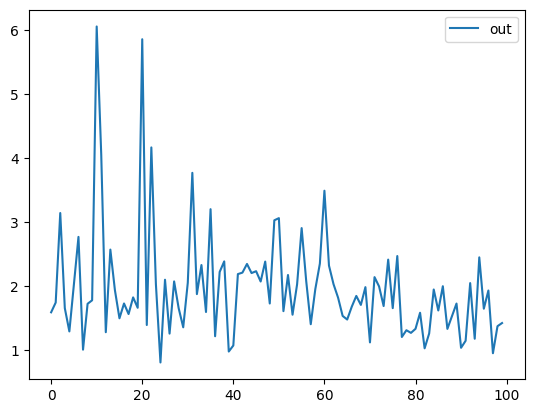

In [34]:
out_df.plot()

In [35]:
out_df.min()

out    0.806748
dtype: float64

# minimum of out

In [36]:
out_df[out_df['out']==out_df['out'].min()]

,out
24,0.806748


In [37]:
attr_df.describe()

,attr
count,1.440000e+03
mean,-7.894919e-17
std,1.000347e+00
min,-1.891524e+00
25%,-6.544973e-01
50%,2.937051e-02
75%,7.491040e-01
max,1.639490e+00
